# Einleitung & Installationen

### Quellen

In [1]:
# Die Codes wurden zum Teil mithilfe von ChatGPT verbessert oder aneindander angeglichen.
# Für die Erstellung des Q-Learning-Codes wurde folgende Quelle verwendet: https://github.com/johnnycode8/gym_solutions
# Der DQN-Code hat sich an der grundsäztlichen Struktur orientiert.

In [2]:
### Installations

In [1]:
!pip install torch
!pip install pickle
!pip install numpy
!pip install gymnasium
!pip install matplotlib
!pip install tqdm

### Imports

In [3]:
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from tqdm import tqdm
import itertools
from tqdm.notebook import tqdm

# Q-Learning

### Version ohne Improvement

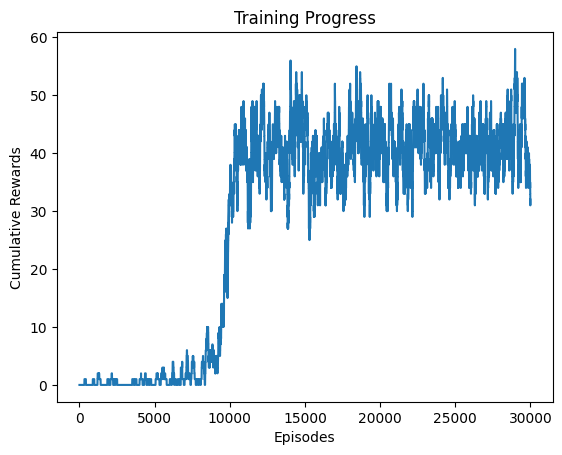

In [6]:
# Q-Learning - Code von https://github.com/johnnycode8/gym_solutions

def run(episodes, is_training=True, render=False):
    # Laden der Umgebung Frozen Lake
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='human' if render else None)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        f = open('frozen_lake8x8.pkl', 'rb')
        q = pickle.load(f)
        f.close()
        
    # Hyperparameter festlegen
    learning_rate_a = 0.9
    discount_factor_g = 0.9
    epsilon = 1
    epsilon_decay_rate = 0.0001
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)
    
    # Fürs Training jede Episode durchlaufen
    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False


        while(not terminated and not truncated):
            
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state,:])

            new_state, reward, terminated, truncated,_ = env.step(action)

            if is_training:
                q[state,action] = q[state,action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
                )


            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if (epsilon==0):
            learning_rate_a = 0.0001

        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()

    # Ergebnisse plotten
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Training Progress')
    plt.savefig('frozen_lake8x8.png')
    plt.savefig('frozen_lake8x8.png')

    if is_training: 
        f = open("frozen_lake8x8.pkl","wb")
        pickle.dump(q, f)
        f.close()

# Training mit 30.000 Episoden starten
if __name__ == '__main__':
    run(30000)

    #Die folgende Zeile nicht mehr Kommentieren, um eine Visualisierung der Durchläufe zu erhalten.
    #run(1000, is_training=False, render=True)

### Q-Learning mit Improvement (Hyperparametertuning)

Training with parameters: lr=0.8, gamma=0.95, epsilon_decay=0.99
Training with parameters: lr=0.8, gamma=0.95, epsilon_decay=0.995
Training with parameters: lr=0.8, gamma=0.99, epsilon_decay=0.99
Training with parameters: lr=0.8, gamma=0.99, epsilon_decay=0.995
Training with parameters: lr=0.9, gamma=0.95, epsilon_decay=0.99
Training with parameters: lr=0.9, gamma=0.95, epsilon_decay=0.995
Training with parameters: lr=0.9, gamma=0.99, epsilon_decay=0.99
Training with parameters: lr=0.9, gamma=0.99, epsilon_decay=0.995
Best Parameters: lr=0.8, gamma=0.95, epsilon_decay=0.99
Best Average Reward: 0.3508677800801003


<Figure size 640x480 with 0 Axes>

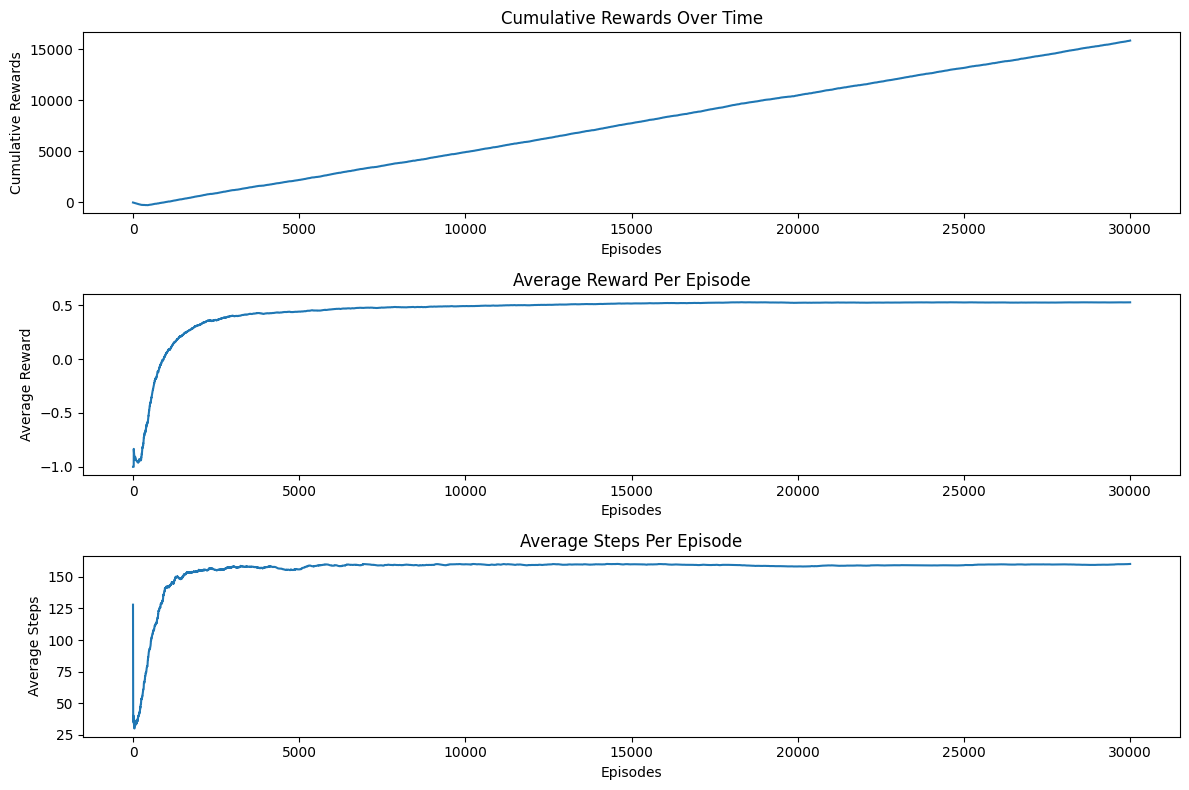

In [5]:
def run(episodes, learning_rate, discount_factor, epsilon_decay, is_training=True, render=False):
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='human' if render else None)

    if is_training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        with open('frozen_lake8x8.pkl', 'rb') as f:
            q_table = pickle.load(f)

    epsilon = 1.0
    epsilon_min = 0.01
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)
    steps_per_episode = np.zeros(episodes)

    for episode in range(episodes):
        state, _ = env.reset()
        terminated = False
        steps = 0

        while not terminated:
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            new_state, reward, terminated, _, _ = env.step(action)
            steps += 1

            # Rewards anpassen
            if terminated and reward == 0:
                reward = -1
            elif not terminated and reward == 0:
                reward = -0.01

            if is_training:
                best_next_action = np.max(q_table[new_state])
                q_table[state, action] = q_table[state, action] + learning_rate * (
                    reward + discount_factor * best_next_action - q_table[state, action]
                )

            state = new_state

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        rewards_per_episode[episode] = reward
        steps_per_episode[episode] = steps

    env.close()

    sum_rewards = np.cumsum(rewards_per_episode)
    avg_rewards = np.cumsum(rewards_per_episode) / (np.arange(episodes) + 1)
    avg_steps = np.cumsum(steps_per_episode) / (np.arange(episodes) + 1)

    if is_training:
        with open("frozen_lake8x8.pkl", "wb") as f:
            pickle.dump(q_table, f)

    return rewards_per_episode, sum_rewards, avg_rewards, avg_steps

def run_tuning(episodes, lr_list, gamma_list, epsilon_decay_list):
    param_combinations = list(itertools.product(lr_list, gamma_list, epsilon_decay_list))
    
    best_avg_reward = -float('inf')
    best_params = None

    for params in param_combinations:
        lr, gamma, epsilon_decay = params
        print(f"Training with parameters: lr={lr}, gamma={gamma}, epsilon_decay={epsilon_decay}")

        rewards_per_episode, _, avg_rewards, _ = run(episodes, lr, gamma, epsilon_decay, is_training=True, render=False)
        
        avg_reward = np.mean(avg_rewards[-100:])  # Durchschnittliche Belohnung der letzten 100 Episoden
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_params = params

        # Plot der Belohnungen pro Episode speichern
        plt.plot(rewards_per_episode)
        plt.title(f"LR: {lr}, Gamma: {gamma}, Epsilon Decay: {epsilon_decay}")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.savefig(f"reward_plot_lr{lr}_gamma{gamma}_epsilon{epsilon_decay}.png")
        plt.clf()

    print(f"Best Parameters: lr={best_params[0]}, gamma={best_params[1]}, epsilon_decay={best_params[2]}")
    print(f"Best Average Reward: {best_avg_reward}")
    return best_params

if __name__ == '__main__':
    # Hyperparameter tuning
    best_params = run_tuning(3000, lr_list=[0.8, 0.9], gamma_list=[0.95, 0.99], epsilon_decay_list=[0.99, 0.995])

    # 30.000 Episoden mit bester Hyperparameter-Kombi trainieren
    rewards, cumulative_rewards, avg_rewards, avg_steps = run(30000, learning_rate=best_params[0], discount_factor=best_params[1], epsilon_decay=best_params[2], is_training=True, render=False)

    # Abbildungen plotten
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(cumulative_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Cumulative Rewards Over Time')

    plt.subplot(3, 1, 2)
    plt.plot(avg_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Per Episode')

    plt.subplot(3, 1, 3)
    plt.plot(avg_steps)
    plt.xlabel('Episodes')
    plt.ylabel('Average Steps')
    plt.title('Average Steps Per Episode')

    plt.tight_layout()
    plt.savefig('frozen_lake8x8_metrics_optimized.png')
    plt.show()

# DQN

### Version ohne Improvement

Training Progress:   0%|          | 0/30000 [00:00<?, ?it/s]

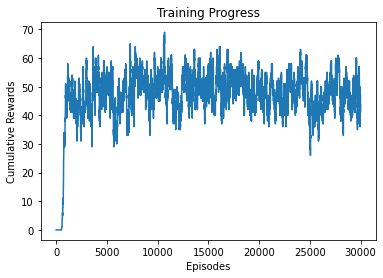

In [12]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def one_hot_encoding(state, num_states):
    state_encoded = np.zeros(num_states)
    state_encoded[state] = 1
    return state_encoded

def run(episodes, is_training=True, render=False):
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='human' if render else None)
    
    input_dim = env.observation_space.n
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if is_training:
        model = DQN(input_dim, output_dim).to(device)
        target_model = DQN(input_dim, output_dim).to(device)
        target_model.load_state_dict(model.state_dict())
        target_model.eval()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        model = DQN(input_dim, output_dim).to(device)
        try:
            with open('frozen_lake8x8.pkl', 'rb') as f:
                q_table = pickle.load(f)
                model.load_state_dict(q_table)
        except FileNotFoundError:
            print("No trained model found. Please run training first.")
            return
        model.eval()

    # Hyperparameter festlegen    
    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.99
    epsilon_min = 0.01
    batch_size = 128
    memory = deque(maxlen=50000)
    optimize_every = 4

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                state_encoded = torch.tensor(one_hot_encoding(state, input_dim), dtype=torch.float32, device=device).unsqueeze(0)
                q_values = model(state_encoded)
                return q_values.argmax().item()
            
    # Funktion zur Optimierung
    def optimize_model():
        if len(memory) < batch_size:
            return
        transitions = random.sample(memory, batch_size)
        batch = list(zip(*transitions))

        states = np.array(batch[0])
        actions = np.array(batch[1])
        rewards = np.array(batch[2])
        next_states = np.array(batch[3])
        dones = np.array(batch[4])

        states = torch.tensor(states, dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        q_values = model(states).gather(1, actions).squeeze()
        next_q_values = target_model(next_states).max(1)[0]
        expected_q_values = rewards + (gamma * next_q_values * (1 - dones))

        loss = nn.MSELoss()(q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    rewards_per_episode = np.zeros(episodes)

    for i in tqdm(range(episodes), desc="Training Progress"):
        state = env.reset()[0]
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            memory.append((one_hot_encoding(state, input_dim), action, reward, one_hot_encoding(next_state, input_dim), float(terminated or truncated)))
            state = next_state

            if is_training and len(memory) >= batch_size and i % optimize_every == 0:
                optimize_model()

        if is_training:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
            if i % 10 == 0:
                target_model.load_state_dict(model.state_dict())

        rewards_per_episode[i] = total_reward

    env.close()

    # Ergebnis plotten
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Training Progress')
    plt.savefig('frozen_lake8x8.png')

    if is_training:
        with open('frozen_lake8x8.pkl', 'wb') as f:
            pickle.dump(model.state_dict(), f)

if __name__ == '__main__':
    # Training mit 30.000 Episoden
    run(30000, is_training=True, render=False)

### DQN mit Improvement - Hyperparametertuning

Training with parameters: lr=0.001, gamma=0.99, epsilon_decay=0.99, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.99, epsilon_decay=0.99, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.99, epsilon_decay=0.995, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.99, epsilon_decay=0.995, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.95, epsilon_decay=0.99, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.95, epsilon_decay=0.99, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.95, epsilon_decay=0.995, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.001, gamma=0.95, epsilon_decay=0.995, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.99, epsilon_decay=0.99, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.99, epsilon_decay=0.99, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.99, epsilon_decay=0.995, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.99, epsilon_decay=0.995, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.95, epsilon_decay=0.99, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.95, epsilon_decay=0.99, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.95, epsilon_decay=0.995, batch_size=64


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Training with parameters: lr=0.0005, gamma=0.95, epsilon_decay=0.995, batch_size=128


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Best Parameters: lr=0.0005, gamma=0.95, epsilon_decay=0.995, batch_size=64
Best Average Reward: 0.49


Training Progress:   0%|          | 0/30000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

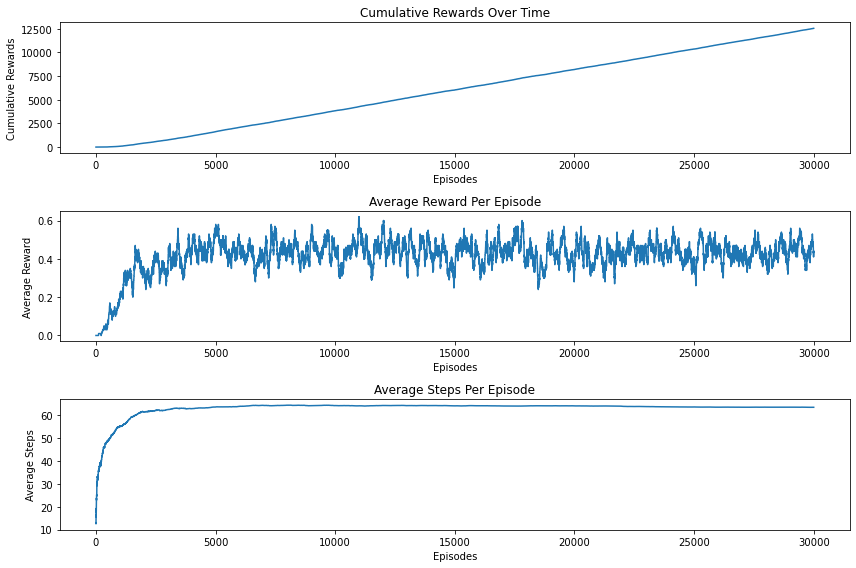

In [11]:
def run_tuning(episodes, lr_list, gamma_list, epsilon_decay_list, batch_size_list):
    
    # Liste mit Kombinationen der Hyperparameter erstellen
    param_combinations = list(itertools.product(lr_list, gamma_list, epsilon_decay_list, batch_size_list))
    
    best_avg_reward = -float('inf')
    best_params = None
    
    # Für jede Kombi einmal Training durchlaufen lassen
    for params in param_combinations:
        lr, gamma, epsilon_decay, batch_size = params
        print(f"Training with parameters: lr={lr}, gamma={gamma}, epsilon_decay={epsilon_decay}, batch_size={batch_size}")

        rewards_per_episode, _, _, _ = run(episodes, lr, gamma, epsilon_decay, batch_size, is_training=True, render=False)
        
        avg_reward = np.mean(rewards_per_episode[-100:])  # Durchschnittliche Belohnung der letzten 100 Episoden
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_params = params

        # Plot der Belohnungen pro Episode speichern
        plt.plot(rewards_per_episode)
        plt.title(f"LR: {lr}, Gamma: {gamma}, Epsilon Decay: {epsilon_decay}, Batch Size: {batch_size}")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.savefig(f"reward_plot_lr{lr}_gamma{gamma}_epsilon{epsilon_decay}_batch{batch_size}.png")
        plt.clf()

    print(f"Best Parameters: lr={best_params[0]}, gamma={best_params[1]}, epsilon_decay={best_params[2]}, batch_size={best_params[3]}")
    print(f"Best Average Reward: {best_avg_reward}")
    return best_params

def run(episodes, lr=0.001, gamma=0.99, epsilon_decay=0.99, batch_size=128, is_training=True, render=False):
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='human' if render else None)
    
    input_dim = env.observation_space.n
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if is_training:
        model = DQN(input_dim, output_dim).to(device)
        target_model = DQN(input_dim, output_dim).to(device)
        target_model.load_state_dict(model.state_dict())
        target_model.eval()
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        model = DQN(input_dim, output_dim).to(device)
        try:
            with open('frozen_lake8x8.pkl', 'rb') as f:
                q_table = pickle.load(f)
                model.load_state_dict(q_table)
        except FileNotFoundError:
            print("No trained model found. Please run training first.")
            return
        model.eval()

    epsilon = 1.0
    epsilon_min = 0.01
    memory = deque(maxlen=50000)
    optimize_every = 4

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                state_encoded = torch.tensor(one_hot_encoding(state, input_dim), dtype=torch.float32, device=device).unsqueeze(0)
                q_values = model(state_encoded)
                return q_values.argmax().item()

    def optimize_model():
        if len(memory) < batch_size:
            return
        transitions = random.sample(memory, batch_size)
        batch = list(zip(*transitions))

        states = np.array(batch[0])
        actions = np.array(batch[1])
        rewards = np.array(batch[2])
        next_states = np.array(batch[3])
        dones = np.array(batch[4])

        states = torch.tensor(states, dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        q_values = model(states).gather(1, actions).squeeze()
        next_q_values = target_model(next_states).max(1)[0]
        expected_q_values = rewards + (gamma * next_q_values * (1 - dones))

        loss = nn.MSELoss()(q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    rewards_per_episode = np.zeros(episodes)
    cumulative_rewards = np.zeros(episodes)
    avg_rewards = np.zeros(episodes)
    avg_steps = np.zeros(episodes)
    
    total_steps = 0

    with tqdm(total=episodes, desc="Training Progress", leave=True) as pbar:
        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False
            total_reward = 0
            steps = 0

            while not terminated and not truncated:
                action = select_action(state, epsilon)
                next_state, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                memory.append((one_hot_encoding(state, input_dim), action, reward, one_hot_encoding(next_state, input_dim), float(terminated or truncated)))
                state = next_state
                steps += 1

                if is_training and len(memory) >= batch_size and i % optimize_every == 0:
                    optimize_model()

            if is_training:
                epsilon = max(epsilon * epsilon_decay, epsilon_min)
                if i % 10 == 0:
                    target_model.load_state_dict(model.state_dict())

            total_steps += steps
            rewards_per_episode[i] = total_reward
            cumulative_rewards[i] = np.sum(rewards_per_episode[:i+1])
            avg_rewards[i] = np.mean(rewards_per_episode[max(0, i-99):i+1])
            avg_steps[i] = total_steps / (i+1)

            pbar.update(1)

    env.close()

    if is_training:
        with open('frozen_lake8x8.pkl', 'wb') as f:
            pickle.dump(model.state_dict(), f)

    return rewards_per_episode, cumulative_rewards, avg_rewards, avg_steps

if __name__ == '__main__':
    # Testen der Hyperparameter mit jeweils 3.000 Episoden
    best_params = run_tuning(3000, lr_list=[0.001, 0.0005], gamma_list=[0.99, 0.95], epsilon_decay_list=[0.99, 0.995], batch_size_list=[64, 128])

    # Training mit den besten Hyperparametern für 30.000 Episoden
    rewards, cumulative_rewards, avg_rewards, avg_steps = run(30000, lr=best_params[0], gamma=best_params[1], epsilon_decay=best_params[2], batch_size=best_params[3], is_training=True, render=False)

    # Abbildungen plotten
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(cumulative_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Cumulative Rewards Over Time')

    plt.subplot(3, 1, 2)
    plt.plot(avg_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Per Episode')

    plt.subplot(3, 1, 3)
    plt.plot(avg_steps)
    plt.xlabel('Episodes')
    plt.ylabel('Average Steps')
    plt.title('Average Steps Per Episode')

    plt.tight_layout()
    plt.savefig('frozen_lake8x8_metrics_optimized.png')
    plt.show()
